In [1]:
from torch.utils.data import Dataset
from torchvision.io import read_image
import torchvision.transforms.v2.functional as F
import random
import os
from torch.utils.data import Dataset
from torchvision.io import read_image
import torchvision.transforms.functional as F
import random
import torch
from sklearn.preprocessing import MultiLabelBinarizer
from transformers import BertTokenizer, BertModel, CLIPProcessor, CLIPModel
from tqdm import tqdm
from torch.utils.data import DataLoader

In [2]:
class FiveKDataset(Dataset):
    def __init__(self, image_size, mode="train", resize=True, 
                 augment_data=False, use_txt_features=False, device='cuda',
                 test_file=None):
        current_dir = os.getcwd()
        dataset_dir = os.path.join(current_dir,"..","dataset")
        self.IMGS_PATH = os.path.join(dataset_dir, "FiveK")
        self.FEATURES_PATH = os.path.join(dataset_dir, "processed_categories_2.txt")
        
        self.resize = resize
        self.image_size = image_size
        self.augment_data = augment_data
        self.use_txt_features = use_txt_features
        self.device = device
        self.mode = mode
        self.img_files = []
        self.features = {}
        self.feature_categories = ["Location", "Time", "Light", "Subject"]
        
        # Load semantic features from processed_categories.txt
        with open(self.FEATURES_PATH, 'r') as f:
            for line in f:
                parts = line.strip().split(',')
                img_name = parts[0]
                img_features = parts[1:]
                self.features[img_name] = img_features
        
        # Load image files
        if mode == "test" and test_file:
            test_file_path = os.path.join(dataset_dir, test_file)
            with open(test_file_path, 'r') as f:
                self.img_files = [line.strip() for line in f]
            self.img_locations = self._locate_test_images()
        else:
            self.img_files = [f for f in os.listdir(os.path.join(self.IMGS_PATH, mode, 'input'))]
        
        all_features = [self.features[img] for img in self.img_files]
        self.mlb = MultiLabelBinarizer()
        self.mlb.fit(all_features)
        
        # Create encoding dictionaries for categorical approach
        unique_features = {cat: set(feat[i] for feat in all_features) 
                           for i, cat in enumerate(self.feature_categories)}
        self.feature_to_idx = {
            cat: {feat: idx for idx, feat in enumerate(sorted(features))}
            for cat, features in unique_features.items()
        }
        
        self.precomputed_bert_features = {}
        self.precomputed_clip_features = {}
        
        if self.use_txt_features == "embedded":
            self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
            self.bert_model = BertModel.from_pretrained('bert-base-uncased')
            self.bert_model.eval()
            self.bert_model.to(self.device)
            self.clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
            self.clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
            self.clip_model.eval()
            self.clip_model.to(self.device)
            self.precompute_features()

    def precompute_features(self):
        print("Precomputing BERT and CLIP features...")
        for img_name in tqdm(self.img_files):
            # Precompute BERT features
            feature_text = " ".join(self.features[img_name])
            inputs = self.tokenizer(feature_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
            with torch.no_grad():              
                outputs = self.bert_model(**inputs.to(self.device))
            bert_features = outputs.last_hidden_state[:, 0, :].squeeze(0)  # Shape: (768,)
            self.precomputed_bert_features[img_name] = bert_features.cpu()

            # Precompute CLIP features
            image_path = os.path.join(self.IMGS_PATH, 'input', img_name)
            image = read_image(image_path)
            clip_inputs = self.clip_processor(images=image, return_tensors="pt")
            with torch.no_grad():           
                clip_features = self.clip_model.get_image_features(**clip_inputs.to(self.device))

            self.precomputed_clip_features[img_name] = clip_features.squeeze(0).cpu()  # Shape: (512,)
        del self.bert_model
        del self.tokenizer    
        del self.clip_model
        del self.clip_processor  
        print("BERT and CLIP features precomputed and stored.")

    def __len__(self):
        return len(self.img_files)

    def _locate_test_images(self):
        locations = {}
        for img in self.img_files:
            if os.path.exists(os.path.join(self.IMGS_PATH, 'train', 'input', img)):
                locations[img] = 'train'
            elif os.path.exists(os.path.join(self.IMGS_PATH, 'test', 'input', img)):
                locations[img] = 'test'
            else:
                raise FileNotFoundError(f"Image {img} not found in train or test folders")
        return locations

    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        if self.mode == "test":
            folder = self.img_locations[img_name]
            source = read_image(os.path.join(self.IMGS_PATH, folder, 'input', img_name))
            target = read_image(os.path.join(self.IMGS_PATH, folder, 'target', img_name))
        else:
            source = read_image(os.path.join(self.IMGS_PATH, self.mode, 'input', img_name))
            target = read_image(os.path.join(self.IMGS_PATH, self.mode, 'target', img_name))

        if self.resize:
                    source = F.resize(source, (self.image_size, self.image_size), interpolation=F.InterpolationMode.BICUBIC)
                    target = F.resize(target, (self.image_size, self.image_size), interpolation=F.InterpolationMode.BICUBIC)

        if self.augment_data:
            if random.random() > 0.5:
                source = F.hflip(source)
                target = F.hflip(target)
            if random.random() > 0.5:
                source = F.vflip(source)
                target = F.vflip(target)

        if not self.use_txt_features:
            return source, target

        elif self.use_txt_features == "one_hot":
            one_hot_features = self.mlb.transform([self.features[img_name]])[0]
            one_hot_features = torch.tensor(one_hot_features, dtype=torch.float32)
            return source, one_hot_features, target

        elif self.use_txt_features == "categorical":
            cat_features = [self.feature_to_idx[cat][feat] for cat, feat in zip(self.feature_categories, self.features[img_name])]
            cat_features = torch.tensor(cat_features, dtype=torch.long)
            return source, cat_features, target

        elif self.use_txt_features == "embedded":
            bert_features = self.precomputed_bert_features[img_name]
            clip_features = self.precomputed_clip_features[img_name]
            return source, bert_features, clip_features, target

        else:
            raise ValueError("Invalid value for use_txt_features. Must be False, 'one_hot', 'categorical', or 'embedded'.")

    def collate_fn(self, batch):
        if self.use_txt_features == "embedded":
            sources, bert_features, clip_features, targets = zip(*batch)
            sources = torch.stack(sources)
            bert_features = torch.stack(bert_features)
            clip_features = torch.stack(clip_features)
            targets = torch.stack(targets)
            return sources, bert_features, clip_features, targets
        else:
            sources, features, targets = zip(*batch)
            sources = torch.stack(sources)
            targets = torch.stack(targets)
            if self.use_txt_features in ["one_hot", "categorical"]:
                features = torch.stack(features)
            else:
                features = None
            return sources, features, targets

In [3]:
test_dataset_512 = FiveKDataset(
    image_size=500,
    mode="test",
    resize=False,
    augment_data=False,
    use_txt_features=False,
    device='cuda',
    test_file="test.txt"
)
test_dataset_64 = FiveKDataset(
    image_size=224,
    mode="test",
    resize=True,
    augment_data=False,
    use_txt_features=False,
    device='cuda',
    test_file="test.txt"
)
test_512 = DataLoader(test_dataset_512, batch_size=1, shuffle = False)
test_64 = DataLoader(test_dataset_64, batch_size=500 , shuffle = False)

In [4]:
test_dataset_64.IMGS_PATH

'/home/zakaria/workspace/ai-photo-enhancer/notebooks/../dataset/FiveK'

In [5]:
import os 
os.chdir('../src')

In [6]:
import torchvision.transforms as transforms
from torchvision.transforms import v2
from torchmetrics.image import StructuralSimilarityIndexMeasure
from envs.new_edit_photo import PhotoEditor
from sac.sac_inference import InferenceAgent
import yaml
from envs.photo_env import PhotoEnhancementEnvTest
import numpy as np
import argparse
import logging
import os
from pathlib import Path
from tqdm import tqdm

In [7]:
DEVICE = 'cuda:0'
class Config(object):
    def __init__(self, dictionary):
        self.__dict__.update(dictionary)

with open(os.path.join("configs/inference_config.yaml")) as f:
    inf_config_dict =yaml.load(f, Loader=yaml.FullLoader)
inference_config = Config(inf_config_dict)
inference_config.device = DEVICE

In [8]:
os.getcwd()

'/home/zakaria/workspace/ai-photo-enhancer/src'

In [9]:
import os 
os.chdir('..')

In [10]:
experiments_path = 'experiments/runs/'
models_path = [os.path.join(experiments_path,model_path) for model_path in os.listdir(experiments_path)]
models_path.remove('experiments/runs/ResNetEncoder__1__1720274282')
models_path.remove('experiments/runs/ResNetEncoder__1__1719841165')
models_path.remove('experiments/runs/SemanticBackbone__semantic_5sliders__2024-07-19_14-08-51')
models_path = models_path[:-1]
models_names = [name.split('/')[-1] for name in models_path]

In [11]:
models_path[-2]

'experiments/runs/SemanticBackbone__6_sliders_244_64__2024-07-21_18-18-08'

In [12]:
all_psnrs = []
all_ssims = []
for model_path in [models_path[-2]]:
    with open(os.path.join(model_path,"configs/sac_config.yaml")) as f:
        sac_config_dict =yaml.load(f, Loader=yaml.FullLoader)
    with open(os.path.join(model_path,"configs/env_config.yaml")) as f:
        env_config_dict =yaml.load(f, Loader=yaml.FullLoader)

    sac_config = Config(sac_config_dict)
    env_config = Config(env_config_dict)
    sac_config.device = DEVICE

    photo_editor = PhotoEditor(env_config.sliders_to_use)

    inference_env = PhotoEnhancementEnvTest(
                        batch_size=env_config.train_batch_size,
                        imsize=env_config.imsize,
                        training_mode=False,
                        done_threshold=env_config.threshold_psnr,
                        edit_sliders=env_config.sliders_to_use,
                        features_size=env_config.features_size,
                        discretize=env_config.discretize,
                        discretize_step= env_config.discretize_step,
                        use_txt_features='cpu' if hasattr(env_config,"use_txt_features") else False,
                        augment_data=False,
                        pre_encoding_device='cpu' if hasattr(env_config,"pre_encoding_device") else 'cpu', 
                        logger=None)
    inference_env.dataloader = test_64
    inference_env.iter_dataloader = iter(test_64)
    inference_env.batch_size = 500 

    batch_64_images = inference_env.reset()
    inf_agent =InferenceAgent(inference_env, inference_config)
    inf_agent.load_backbone(os.path.join(model_path,'models','backbone.pth'))
    inf_agent.load_actor_weights(os.path.join(model_path,'models','actor_head.pth'))
    inf_agent.load_critics_weights( os.path.join(model_path,'models','qf1_head.pth'), os.path.join(model_path,'models','qf2_head.pth'))

    ssim_metric = StructuralSimilarityIndexMeasure().cuda()

    
    PSNRS = []
    SSIM = []

    parameters_1 = inf_agent.act(obs=batch_64_images[:250,...].cuda(),deterministic=False)
    parameters_2 =  inf_agent.act(obs=batch_64_images[250:,...].cuda(),deterministic=False)
    parameters = torch.cat((parameters_1,parameters_2),0)
    
    parameter_counter = 0
    for i,t in tqdm(test_512, position=0, leave=True):
        source = i/255.0
        target = t/255.0 
        enhanced_image = photo_editor((source.permute(0,2,3,1)).cuda(),parameters[parameter_counter].unsqueeze(0).cuda())
        psnr = inference_env.compute_rewards(enhanced_image.permute(0,3,1,2).cuda(),target.cuda()).item()+50
        ssim = ssim_metric(enhanced_image.permute(0,3,1,2).cuda(),target.cuda()).item()
        PSNRS.append(psnr)
        SSIM.append(ssim)
        parameter_counter+=1
    mean_PSNRS = round(np.mean(PSNRS),2)
    mean_SSIM = round(np.mean(SSIM),3)
    all_psnrs.append(mean_PSNRS)
    all_ssims.append(mean_SSIM)

Preloading images and features...


100%|██████████| 500/500 [00:01<00:00, 273.22it/s]


Images and features preloaded and stored in GPU memory.


100%|██████████| 500/500 [00:11<00:00, 44.02it/s]


In [13]:
all_psnrs

[24.23]

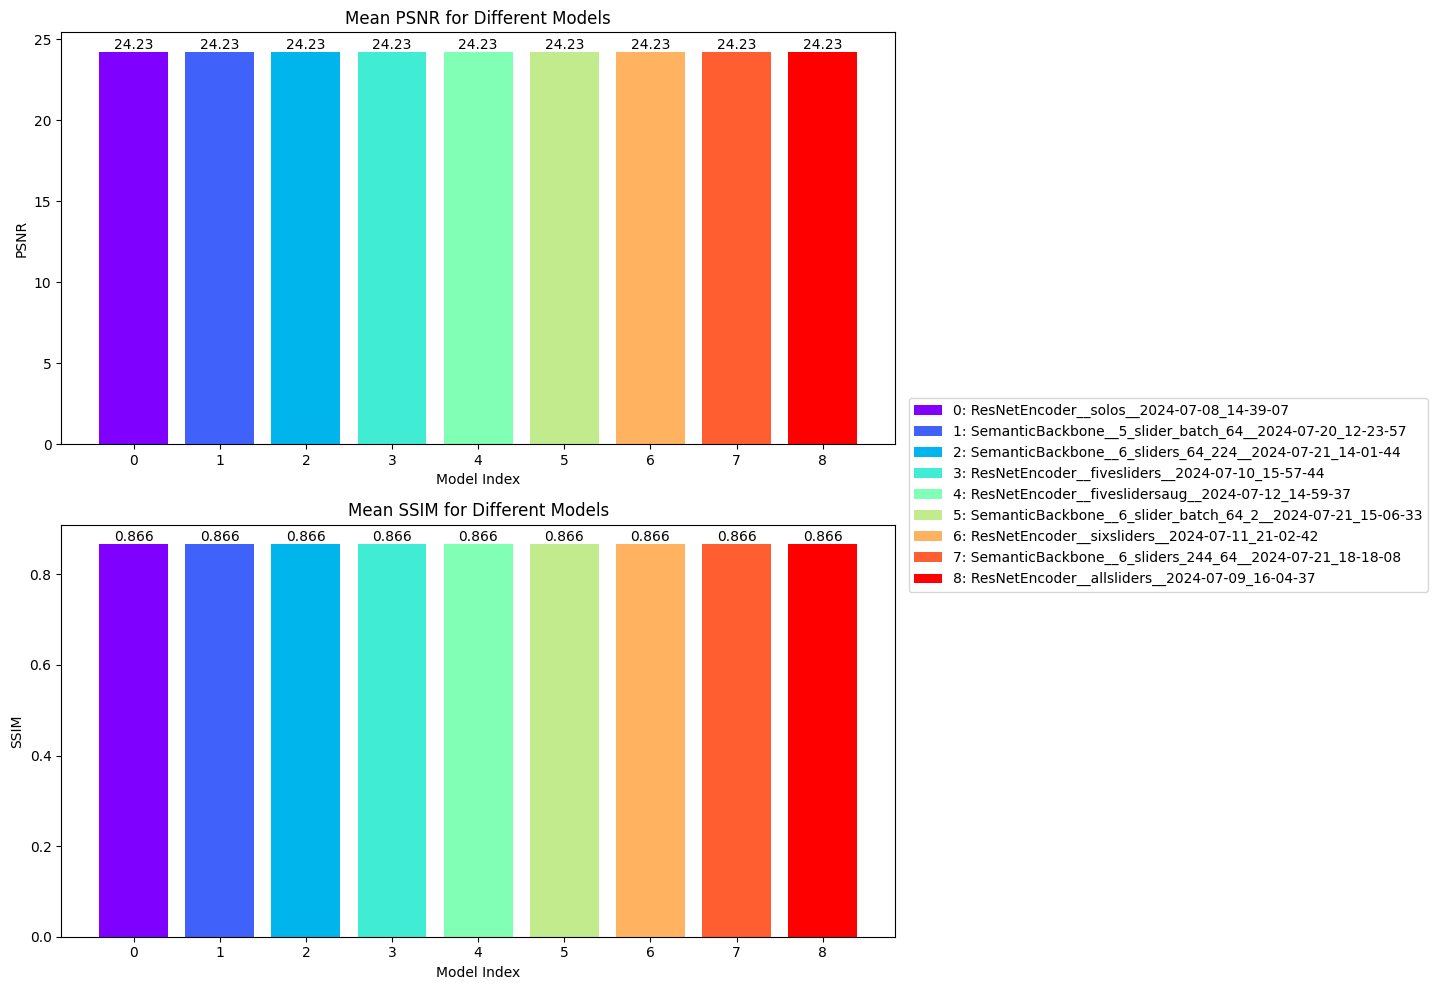

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming all_psnrs, all_ssims, and models_names are already defined
# and models_names[:-1] is used to exclude the last model

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Generate indices for x-axis
indices = range(len(models_names))

# Generate a colormap
colors = plt.cm.rainbow(np.linspace(0, 1, len(indices)))

# PSNR plot
bars1 = ax1.bar(indices, all_psnrs, color=colors)
ax1.set_title('Mean PSNR for Different Models')
ax1.set_xlabel('Model Index')
ax1.set_ylabel('PSNR')
ax1.set_xticks(indices)

# Add value labels on the bars for PSNR
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

# SSIM plot
bars2 = ax2.bar(indices, all_ssims, color=colors)
ax2.set_title('Mean SSIM for Different Models')
ax2.set_xlabel('Model Index')
ax2.set_ylabel('SSIM')
ax2.set_xticks(indices)

# Add value labels on the bars for SSIM
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom')

# Create legend
legend_labels = [f"{i}: {name}" for i, name in enumerate(models_names)]
fig.legend(bars1, legend_labels, loc='center right', bbox_to_anchor=(1.2, 0.5))

plt.tight_layout()
plt.subplots_adjust(right=0.75)  # Adjust this value to make room for the legend
plt.show()